# Milestone 2

Annesa Fadhila Damayanti

Batch 11

## Problem

Detection if that person using mask or not using CNN Model
- https://www.kaggle.com/datasets/omkargurav/face-mask-dataset?select=data

# Import Library

In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import json

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

In [3]:
!mkdir -p ~/.kaggle 
!cp kaggle.json ~/.kaggle 

!mkdir ./kaggle 
!mv ./kaggle.json ./kaggle 

!chmod 600 ~/.kaggle/kaggle.json 
!ls ~/.kaggle 

kaggle.json


In [4]:
!kaggle datasets download -d omkargurav/face-mask-dataset

 93% 152M/163M [00:01<00:00, 123MB/s]
100% 163M/163M [00:01<00:00, 154MB/s]


In [5]:
!unzip -q /content/face-mask-dataset.zip -d images

In [6]:
os.listdir('/content/images/data')

['with_mask', 'without_mask']

In [7]:
main_path = '/content/images/data'
mask_dir = os.path.join(main_path, 'with_mask')
nomask_dir = os.path.join(main_path, 'without_mask')

In [8]:
num_mask = len(os.listdir(os.path.join(main_path, 'with_mask')))
num_nomask = len(os.listdir(os.path.join(main_path, 'without_mask')))

In [9]:
print('Mask', num_mask)
print('No Mask', num_nomask)

Mask 3725
No Mask 3828


the different betweet with_mask and without_mask not that quite different. without_mask data has more data than with_mask.

In [10]:
mask = glob.glob(main_path + '/with_mask/*.jpg')
nomask = glob.glob(main_path + '/without_mask/*.jpg')

In [11]:
def create_dataframe(list_of_images):
  data=[]
  for image in list_of_images:
    data.append((image, image.split('/')[-2]))
  return pd.DataFrame(data, columns= ['images','label'])

df = create_dataframe(mask + nomask)
print(df.shape)
df

(7553, 2)


,images,label
0,/content/images/data/with_mask/with_mask_1158.jpg,with_mask
1,/content/images/data/with_mask/with_mask_3664.jpg,with_mask
2,/content/images/data/with_mask/with_mask_2956.jpg,with_mask
3,/content/images/data/with_mask/with_mask_3046.jpg,with_mask
4,/content/images/data/with_mask/with_mask_1032.jpg,with_mask
...,...,...
7548,/content/images/data/without_mask/without_mask...,without_mask
7549,/content/images/data/without_mask/without_mask...,without_mask
7550,/content/images/data/without_mask/without_mask...,without_mask
7551,/content/images/data/without_mask/without_mask...,without_mask


In [12]:
data = df.copy()

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7553 entries, 0 to 7552
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  7553 non-null   object
 1   label   7553 non-null   object
dtypes: object(2)
memory usage: 118.1+ KB


all the data is object and there is no missing value in this data.

In [14]:
# Check duplicate in the dataset
df[df.duplicated(keep=False)]

,images,label


there is no duplicate data

# EDA

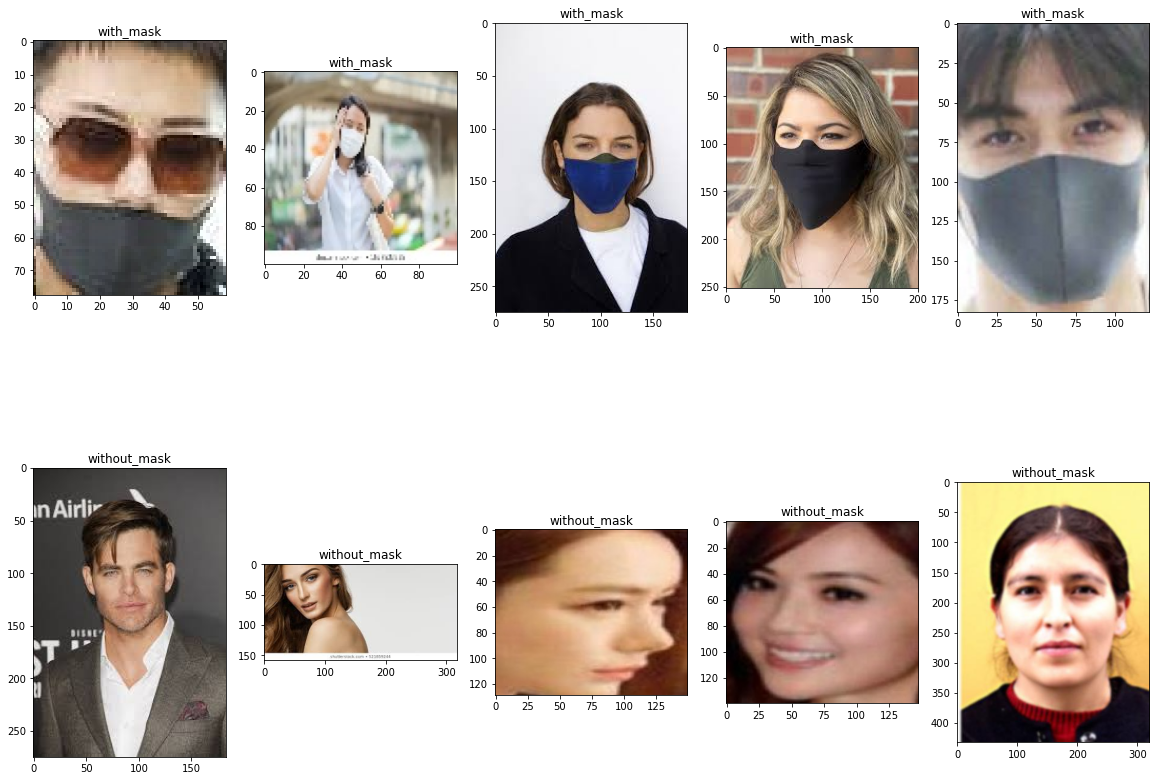

In [15]:
mask_samples= (df[df['label']=='with_mask']['images'].iloc[:5]).tolist()
nomask_samples= (df[df['label']=='without_mask']['images'].iloc[:5]).tolist()

def visualize_samples(samples):
  fig,ax= plt.subplots(nrows=2, ncols=5, figsize= (20,15))
  for i, sample in enumerate(samples):
    img= cv2.imread(sample)
    ax[i//5, i%5].set_title(sample.split('/')[-2])
    ax[i//5, i%5].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

visualize_samples(mask_samples + nomask_samples)

here's the different between with_mask and without_mask. as you can see in the photos we can see clearly if the person is using mask or not.

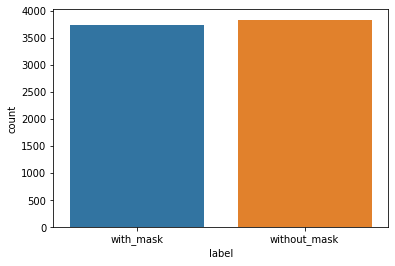

In [16]:
sns.countplot(data=df, x='label')

as i assumed before, without_mask data has more photos than with_mask.

# Data Preprocessing

In [17]:
# get data inference
df_inf = df.sample(20, random_state=400)
# Reset The Index
df_real = df.drop(df_inf.index)
df_real.reset_index(drop=True, inplace=True)
df_inf.reset_index(drop=True, inplace=True)

In [18]:
# Split The Data X and y
X = df_real.drop(['label'], axis=1)
y = df_real['label']

In [19]:
# Split the Data to Train, Test, Val
train_full, test = train_test_split(df_real, test_size=0.2, random_state=10)

train, val = train_test_split(train_full, test_size=0.8, random_state=10)

In [20]:
print('Size train : ', train.shape)
print('Size test : ', test.shape)
print('Size val : ', val.shape)

Size train :  (1205, 2)
Size test :  (1507, 2)
Size val :  (4821, 2)


the size of each train, test, and val

In [21]:
print('train : ', train.isnull().sum())
print('test : ', test.isnull().sum())
print('val : ', val.isnull().sum())

train :  images    0
label     0
dtype: int64
test :  images    0
label     0
dtype: int64
val :  images    0
label     0
dtype: int64


there is no missing values in train, test, and val

# Model Definition

In [22]:
# Data Augmentation
img_height = 200
img_width = 200
SEED = 100
BATCH = 100

train_gen = ImageDataGenerator(rescale=1./255, rotation_range=0.4, width_shift_range=0.4, horizontal_flip=True)
test_gen = ImageDataGenerator(rescale=1./255,  rotation_range=0.4, width_shift_range=0.4, horizontal_flip=True)
val_gen = ImageDataGenerator(rescale=1./255,  rotation_range=0.4, width_shift_range=0.4, horizontal_flip=True)

In [23]:
# Create Pipeline Tensorflow

# Train
ds_train = train_gen.flow_from_dataframe(dataframe =train, x_col ='images', y_col ='label', target_size =(img_height,img_width), class_mode ='binary', batch_size =BATCH,seed =SEED, shuffle =True)

# Test
ds_test = test_gen.flow_from_dataframe(dataframe =test, x_col ='images', y_col ='label', target_size =(img_height,img_width), class_mode ='binary', batch_size =BATCH,seed=SEED, shuffle =True)

# Val
ds_val = val_gen.flow_from_dataframe(dataframe =val, x_col ='images', y_col ='label', target_size =(img_height,img_width), class_mode ='binary', batch_size =BATCH,seed=SEED, shuffle =True)

Found 1205 validated image filenames belonging to 2 classes.
Found 1507 validated image filenames belonging to 2 classes.
Found 4821 validated image filenames belonging to 2 classes.


In [24]:
# Callbacks
callbacks= [
            EarlyStopping(monitor= 'val_loss', mode='min', patience= 3, verbose=1)
]

# Model Training

In [25]:
input =[img_height,img_width,3]

# Conv 1
cnn = Sequential()
cnn.add(Conv2D(filters=16,kernel_size=3, activation='relu', input_shape=input))
cnn.add(MaxPooling2D(pool_size=2))

# Conv 2
cnn.add(Conv2D(filters=32,kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=2))

# Hidden Layers
cnn.add(Flatten())
cnn.add(Dense(64, activation='relu'))
cnn.add(Dense(1, activation='sigmoid'))

In [26]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 73728)             0         
                                                                 
 dense (Dense)               (None, 64)                4

In [27]:
# Compile
cnn.compile(optimizer=Adam(), loss='binary_crossentropy', metrics='accuracy')

# Train
cnn_history = cnn.fit(ds_train, epochs=25, validation_data=(ds_val), callbacks=callbacks)

Epoch 1/25
13/13 [==============================] - 85s 6s/step - loss: 1.4834 - accuracy: 0.5718 - val_loss: 0.6746 - val_accuracy: 0.5847
Epoch 2/25
13/13 [==============================] - 60s 5s/step - loss: 0.5957 - accuracy: 0.6573 - val_loss: 0.4893 - val_accuracy: 0.7766
Epoch 3/25
13/13 [==============================] - 59s 5s/step - loss: 0.4386 - accuracy: 0.8083 - val_loss: 0.4009 - val_accuracy: 0.8309
Epoch 4/25
13/13 [==============================] - 58s 5s/step - loss: 0.4221 - accuracy: 0.8058 - val_loss: 0.3886 - val_accuracy: 0.8355
Epoch 5/25
13/13 [==============================] - 57s 5s/step - loss: 0.3844 - accuracy: 0.8299 - val_loss: 0.3903 - val_accuracy: 0.8268
Epoch 6/25
13/13 [==============================] - 58s 5s/step - loss: 0.3594 - accuracy: 0.8523 - val_loss: 0.3624 - val_accuracy: 0.8513
Epoch 7/25
13/13 [==============================] - 59s 5s/step - loss: 0.3260 - accuracy: 0.8647 - val_loss: 0.3614 - val_accuracy: 0.8442
Epoch 8/25
13/13 [==

from this train, we can see that the accuracy for the training is 0.89 and for validation is 0.85. and got early stopping before finish the epochs training. that means the validation loss reach the early stop threshold

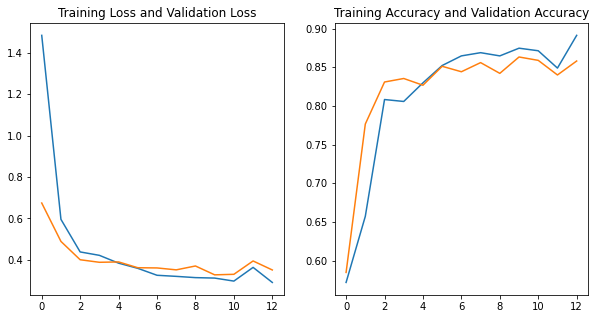

In [28]:
# Create Dataframe for the Data
df_cnn = pd.DataFrame(cnn_history.history)

# Plotting the Data
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Training Loss and Validation Loss')
plt.plot(df_cnn[['loss','val_loss']])

plt.subplot(1,2,2)
plt.title('Training Accuracy and Validation Accuracy')
plt.plot(df_cnn[['accuracy','val_accuracy']])

plt.show()

as you can see, the data already in the FIT situation. that means the data is training

# Model Evaluation

In [65]:
# Evaluation of CNN
cnn.evaluate(ds_test)

16/16 [==============================] - 19s 1s/step - loss: 0.3096 - accuracy: 0.8852


[0.30957090854644775, 0.8852024078369141]

for the test accuracy, we got the accuracy 0.88

that means, is good to predict

In [29]:
# Indicate the y_test
y_test = ds_test.classes

# Prediction
pred_cnn = cnn.predict(ds_test)

# Threshold
pred_cnn = np.where(pred_cnn >= 0.5,1,0)

print('CNN Classification Report')
print(classification_report(y_test,pred_cnn))

CNN Classification Report
              precision    recall  f1-score   support

           0       0.52      0.50      0.51       777
           1       0.49      0.51      0.50       730

    accuracy                           0.50      1507
   macro avg       0.50      0.50      0.50      1507
weighted avg       0.50      0.50      0.50      1507



from the classification report, we can see that this model can only be predicted not that good because it only got 0.50, eventhough the data is fit and got accuracy 0.87 but for predict, not that good. and also, this model have a lot of error.

so we should try to improve the model

## Model Improvement

In [30]:
input =[img_height,img_width,3]

# Improvement Model
cnn_imp = Sequential()

# Conv 1
cnn_imp.add(Conv2D(filters=64,kernel_size=3, activation='relu', input_shape=input, kernel_regularizer= tf.keras.regularizers.L2()))
cnn_imp.add(MaxPooling2D(pool_size=2, strides=2))

# Hidden Layers
cnn_imp.add(Dense(32, activation='relu'))
cnn_imp.add(Dense(16, activation='relu'))
cnn_imp.add(Dropout(rate=0.5))

# Conv 2
cnn_imp.add(Conv2D(filters=128,kernel_size=3, activation='relu', kernel_regularizer= tf.keras.regularizers.L2()))
cnn_imp.add(MaxPooling2D(pool_size=2, strides=2))

# Hidden Layers
cnn_imp.add(Flatten())
cnn_imp.add(Dense(64, activation='relu'))
cnn_imp.add(Dense(32, activation='relu'))
cnn_imp.add(Dense(16, activation='relu'))
cnn_imp.add(Dropout(rate=0.5))
cnn_imp.add(Dense(1, activation='sigmoid'))

In [31]:
cnn_imp.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 198, 198, 64)      1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 99, 99, 64)       0         
 2D)                                                             
                                                                 
 dense_2 (Dense)             (None, 99, 99, 32)        2080      
                                                                 
 dense_3 (Dense)             (None, 99, 99, 16)        528       
                                                                 
 dropout (Dropout)           (None, 99, 99, 16)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 97, 97, 128)       18560     
                                                      

In [32]:
# Compile
cnn_imp.compile(optimizer=Adam(), loss='binary_crossentropy', metrics='accuracy')

# Train
cnn_imp_history = cnn_imp.fit(ds_train, epochs=25, validation_data=(ds_val), callbacks=callbacks)

Epoch 1/25
13/13 [==============================] - 63s 5s/step - loss: 1.4944 - accuracy: 0.5427 - val_loss: 0.9618 - val_accuracy: 0.4931
Epoch 2/25
13/13 [==============================] - 61s 5s/step - loss: 0.9391 - accuracy: 0.5527 - val_loss: 0.9136 - val_accuracy: 0.5063
Epoch 3/25
13/13 [==============================] - 60s 5s/step - loss: 0.8975 - accuracy: 0.5817 - val_loss: 0.8799 - val_accuracy: 0.5105
Epoch 4/25
13/13 [==============================] - 60s 5s/step - loss: 0.8648 - accuracy: 0.5535 - val_loss: 0.8560 - val_accuracy: 0.6237
Epoch 5/25
13/13 [==============================] - 60s 5s/step - loss: 0.8436 - accuracy: 0.5826 - val_loss: 0.8380 - val_accuracy: 0.6453
Epoch 6/25
13/13 [==============================] - 61s 5s/step - loss: 0.8274 - accuracy: 0.5768 - val_loss: 0.8284 - val_accuracy: 0.5067
Epoch 7/25
13/13 [==============================] - 60s 5s/step - loss: 0.8059 - accuracy: 0.5892 - val_loss: 0.8107 - val_accuracy: 0.6387
Epoch 8/25
13/13 [==

from this improvement train, we can see that the accuracy for the training is 0.79 and for validation is 0.84. and got no early stopping before finish the epochs training.

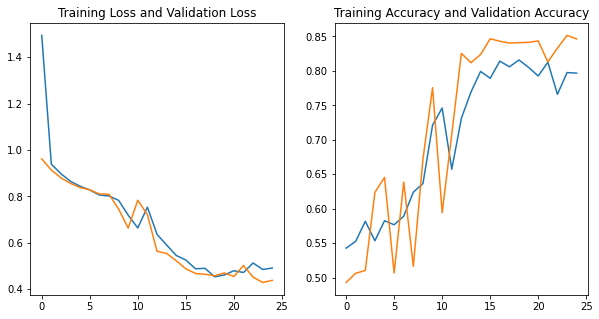

In [33]:
# Create Dataframe for the Data
df_cnn_imp = pd.DataFrame(cnn_imp_history.history)

# Plotting the Data
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Training Loss and Validation Loss')
plt.plot(df_cnn_imp[['loss','val_loss']])

plt.subplot(1,2,2)
plt.title('Training Accuracy and Validation Accuracy')
plt.plot(df_cnn_imp[['accuracy','val_accuracy']])

plt.show()

as you can see, the data already in the fit situation but little bit got overfit that means the data is training quite good but also bad

In [66]:
# Evaluate of Model Improvement
cnn_imp.evaluate(ds_test)

16/16 [==============================] - 15s 921ms/step - loss: 0.4245 - accuracy: 0.8600


[0.4245493412017822, 0.8599867224693298]

for the test accuracy, we got the accuracy 0.86

that means, is good to predict

In [34]:
# Indicate the y_test
y_test_imp = ds_test.classes

# Prediction
pred_cnn_imp = cnn_imp.predict(ds_test)

# Threshold
pred_cnn_imp = np.where(pred_cnn_imp >= 0.5,1,0)

print('CNN Classification Report Model Improvement')
print(classification_report(y_test_imp,pred_cnn_imp))

CNN Classification Report Model Improvement
              precision    recall  f1-score   support

           0       0.52      0.51      0.51       777
           1       0.49      0.50      0.49       730

    accuracy                           0.50      1507
   macro avg       0.50      0.50      0.50      1507
weighted avg       0.50      0.50      0.50      1507



from the classification report, we can see that this model can only be predicted not that good because it only got 0.51, eventhough the data is little bit overfit but got predict is better than before. but also this predict cannot be good for predict because it only got 51% true for predict.

***i already do a lot of way (or code) to make this train and test data to have good prediction, and end up got nothing but more bad than this model.***

# Model Saving

In [68]:
# Save The Model
cnn.save('CNN_Model')

INFO:tensorflow:Assets written to: CNN_Model/assets


In [69]:
# Save The Improvemnet Model
cnn_imp.save('CNN_Imp_Model')

INFO:tensorflow:Assets written to: CNN_Imp_Model/assets


# Model Inference

In [36]:
df_inf

,images,label
0,/content/images/data/without_mask/without_mask...,without_mask
1,/content/images/data/with_mask/with_mask_2306.jpg,with_mask
2,/content/images/data/with_mask/with_mask_3339.jpg,with_mask
3,/content/images/data/without_mask/without_mask...,without_mask
4,/content/images/data/with_mask/with_mask_1828.jpg,with_mask
5,/content/images/data/with_mask/with_mask_3250.jpg,with_mask
6,/content/images/data/with_mask/with_mask_3698.jpg,with_mask
7,/content/images/data/with_mask/with_mask_2790.jpg,with_mask
8,/content/images/data/with_mask/with_mask_758.jpg,with_mask
9,/content/images/data/with_mask/with_mask_1950.jpg,with_mask


In [37]:
# Data Augmentation Model Inference
img_height = 20
img_width = 20
SEED = 10
BATCH = 10

inf_gen = ImageDataGenerator(rescale=1./255, rotation_range=0.4, width_shift_range=0.4, horizontal_flip=True)

# Create Pipeline Tensorflow Model Inference
ds_inf = inf_gen.flow_from_dataframe(dataframe =train, x_col ='images', y_col ='label', target_size =(img_height,img_width), class_mode ='binary', batch_size =BATCH,seed =SEED, shuffle =True)

# Callbacks
callback= [EarlyStopping(monitor= 'val_loss', mode='min', patience= 3, verbose=1)]

Found 1205 validated image filenames belonging to 2 classes.


In [38]:
input =[img_height,img_width,3]

# Conv 1
inf_cnn = Sequential()
inf_cnn.add(Conv2D(filters=16,kernel_size=3, activation='relu', input_shape=input))
inf_cnn.add(MaxPooling2D(pool_size=2))

# Conv 2
inf_cnn.add(Conv2D(filters=32,kernel_size=3, activation='relu'))
inf_cnn.add(MaxPooling2D(pool_size=2))

# Hidden Layers
inf_cnn.add(Flatten())
inf_cnn.add(Dense(64, activation='relu'))
inf_cnn.add(Dense(1, activation='sigmoid'))

In [39]:
inf_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 18, 18, 16)        448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 9, 9, 16)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 32)          4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 3, 3, 32)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 288)               0         
                                                                 
 dense_8 (Dense)             (None, 64)               

In [40]:
# Compile
inf_cnn.compile(optimizer=Adam(), loss='binary_crossentropy', metrics='accuracy')

# Train
cnn_inf_history = inf_cnn.fit(ds_inf, epochs=10, validation_data=(ds_inf), callbacks=callbacks)

Epoch 1/10
121/121 [==============================] - 7s 57ms/step - loss: 0.6476 - accuracy: 0.6158 - val_loss: 0.5841 - val_accuracy: 0.6274
Epoch 2/10
121/121 [==============================] - 7s 55ms/step - loss: 0.4721 - accuracy: 0.7842 - val_loss: 0.3825 - val_accuracy: 0.8548
Epoch 3/10
121/121 [==============================] - 8s 67ms/step - loss: 0.3715 - accuracy: 0.8423 - val_loss: 0.4059 - val_accuracy: 0.8141
Epoch 4/10
121/121 [==============================] - 7s 56ms/step - loss: 0.3678 - accuracy: 0.8440 - val_loss: 0.4214 - val_accuracy: 0.8025
Epoch 5/10
121/121 [==============================] - 7s 55ms/step - loss: 0.3785 - accuracy: 0.8432 - val_loss: 0.3186 - val_accuracy: 0.8730
Epoch 6/10
121/121 [==============================] - 7s 55ms/step - loss: 0.3283 - accuracy: 0.8680 - val_loss: 0.3085 - val_accuracy: 0.8780
Epoch 7/10
121/121 [==============================] - 7s 56ms/step - loss: 0.3153 - accuracy: 0.8730 - val_loss: 0.3045 - val_accuracy: 0.8788

from this improvement train, we can see that the accuracy for the training is 0.89 and same for validation. and got no early stopping before finish the epochs training.

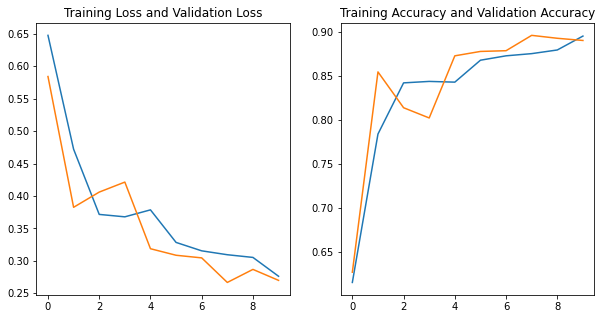

In [41]:
# Create Dataframe for the Data Inference
df_cnn_inf = pd.DataFrame(cnn_inf_history.history)

# Plotting the Data Inference
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Training Loss and Validation Loss')
plt.plot(df_cnn_inf[['loss','val_loss']])

plt.subplot(1,2,2)
plt.title('Training Accuracy and Validation Accuracy')
plt.plot(df_cnn_inf[['accuracy','val_accuracy']])

plt.show()

as you can see, the data already in the FIT situation. that means the data is training

In [64]:
inf_cnn.evaluate(ds_inf)

121/121 [==============================] - 7s 59ms/step - loss: 0.2730 - accuracy: 0.8871


[0.27302804589271545, 0.8871369361877441]

for the test accuracy, we got the accuracy 0.88

that means, is good to predict

In [59]:
# Indicate the y_test
y_test_inf = ds_inf.classes

# Prediction
pred_cnn_inf = inf_cnn.predict(ds_inf)

# Threshold
pred_cnn_inf = np.where(pred_cnn_inf >= 0.5,1,0)

print('CNN Classification Report Model Inference')
print(classification_report(y_test_inf,pred_cnn_inf))

CNN Classification Report Model Inference
              precision    recall  f1-score   support

           0       0.46      0.41      0.43       557
           1       0.53      0.58      0.56       648

    accuracy                           0.50      1205
   macro avg       0.50      0.50      0.49      1205
weighted avg       0.50      0.50      0.50      1205



from the classification report, we can see that this model can only be predicted is bad because it only got 0.43 not event got half of it, eventhough the data is quite fit but got predict really bad.

In [60]:
# Create DataFrame Model Inference Predict
dfinf_pred = pd.DataFrame(pred_cnn_inf, columns=['Prediction'])

# See Actual Data and the Prediction
dfinf_final = pd.concat([(df_inf['label']), (dfinf_pred)], axis=1)
dfinf_final.head(20)

,label,Prediction
0,without_mask,1
1,with_mask,0
2,with_mask,1
3,without_mask,0
4,with_mask,1
5,with_mask,0
6,with_mask,1
7,with_mask,0
8,with_mask,0
9,with_mask,1


as you can see, the prediciton is really bad. from 20 data inference. and more than half of it got the wrong predict. that means this data cannot be predict with this model.

# Conclusion

Basic Model
- the training part, we can see that the accuracy for the training is 0.89 and for validation is 0.85. and got early stopping before finish the epochs training. that means the validation loss reach the early stop threshold
- as you can see, the data already in the FIT situation. that means the data is training
- for the test accuracy, we got the accuracy 0.88. that means, it should be good to predict the data
- but after predict, the classification report, we can see that this model can only be predicted not that good because it only got 0.50, eventhough the data is fit and got accuracy 0.87 but for prediction, not that good. and also, this model have a lot of error.
- i already try another training code, they also got not more than 50% true prediction.
- so we try to do the improvement

Improve Model
- the improvement train part , we can see that the accuracy for the training is 0.79 and for validation is 0.84. and got no early stopping before finish the epochs training.
- as you can see, the data already in the fit situation but little bit got overfit that means the data is training quite good but also bad
- for the test accuracy, we got the accuracy 0.86. that means, it should be better than before.
- and also for the classification report, we can see that this model can only be predicted not that good because it only got 0.51(but better than before), eventhough the data is little bit overfit but got predict is better than before. but also this predict cannot be good for predict because it only got 51% true for predict.
- also i already did another code training, but still. got nothing but more bad than this model.

for the data inference i used the basic model. because with the basic model is training good beacuse the model is fit. and i think with data fit it will predict good. eventhough the classification report only got 50% true predict. but the data is training well.

Inference Model
- the improvement train part, we can see that the accuracy for the training is 0.89 and same for validation. and got no early stopping before finish the epochs training.
- as you can see, the data already in the FIT situation. that means the data is training
- for the test accuracy, we got the accuracy 0.88. that means, is good to predict
- from the classification report, we can see that this model can only be predicted is bad because it only got 0.43 not event got half of it, eventhough the data is quite fit but got predict really bad.


my assumption is really bad. with the basic model, the data infernce cannot predict well. because not more than half of data inference can be true predict. but the data is really good at training because it got fit situation. i dont know why the prediciton can be really that bad. im still learning that why that so.

i think this data cant be predict with CNN model. 

eventhough the accuracy is more than 80% it doesnt mean the prediction can be good. we should still looking for better model to predict the data. and also i should more studying about this kind of case, because im still a student so i need more study to masters this.

im so sorry